In [5]:
import random
import torch
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from torch import nn
from collections import deque 
import torch.nn.functional as F
import torchvision.transforms as T
import cv2

In [6]:
### Define exploration profile
initial_value = 5
num_iterations =  500 #2000
exp_decay = np.exp(-np.log(initial_value) / num_iterations * 6) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]

In [7]:
action_space = [
            (-1, 1, 0.2), (0, 1, 0.2), (1, 1, 0.2), #           Action Space Structure
            (-1, 1,   0), (0, 1,   0), (1, 1,   0), #        (Steering Wheel, Gas, Break)
            (-1, 0, 0.2), (0, 0, 0.2), (1, 0, 0.2), # Range        -1~1       0~1   0~1
            (-1, 0,   0), (0, 0,   0), (1, 0,   0)
        ]

In [8]:
env = gym.make('CarRacing-v0') # Initialize the Gym environment
env.seed(0) # Set a random seed for the environment (reproducible results)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

STATE SPACE SIZE: 96
ACTION SPACE SIZE: Box([-1.  0.  0.], [1. 1. 1.], (3,), float32)


In [9]:
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity) # Define a queue with maxlen "capacity"
    def push(self, state, action, next_state, reward):
        self.memory.append((state,action,next_state,reward))
    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        return random.sample(self.memory, batch_size) # Randomly select "batch_size" samples
    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

# crop func

In [30]:
resize = T.Compose([T.ToPILImage(),T.ToTensor()])
def CroppImage(img):
    cropped = img[:83,:,:].transpose((2, 0, 1))
    croppedTroch = torch.from_numpy(cropped.copy())
    sc_crop = resize(croppedTroch)
    return sc_crop.unsqueeze(0)

Track generation: 1181..1480 -> 299-tiles track
(96, 96, 3)
(96, 96, 3)


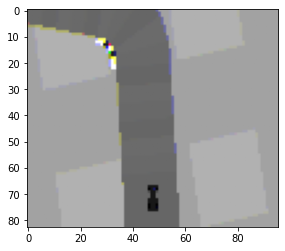

In [33]:
state = env.reset()
for i in range(300):
    action = random.choice(action_space)
    next_state, reward, done, info = env.step(action)
    if(i==297):
        ch1 = cv2.cvtColor(next_state, cv2.COLOR_BGR2GRAY)
    elif(i ==298):
        ch2 = cv2.cvtColor(next_state, cv2.COLOR_BGR2GRAY)
    elif(i==299):
        ch3 = cv2.cvtColor(next_state, cv2.COLOR_BGR2GRAY)
        
merged = cv2.merge([ch1, ch2, ch3 ])        
env.close()
print(np.shape(next_state))
gray = cv2.cvtColor(next_state, cv2.COLOR_BGR2GRAY)
print(merged.shape)
plt.imshow(CroppImage(next_state).squeeze(0).permute(1, 2, 0).numpy())
plt.imshow(CroppImage(merged).squeeze(0).permute(1, 2, 0).numpy())
# plt.imshow(merged)
# cv2.imshow("Merged", merged)

In [12]:
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done and score < 10:
      # Choose a random action
        action = random.choice(action_space)
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
        next_state, reward, done, info = env.step(action)
        print(next_state)
      # Visually render the environment (optional, comment this line to speed up the simulation)
        env.render()
      # Update the final score (+1 for each step)
        score += reward 
      # Set the current state for the next iteration
        state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 

env.close()

Track generation: 1087..1369 -> 282-tiles track
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]


[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

  [  0   0   0]]]
[[[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  

[[[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

  [  0   0   0]]]
[[[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  

[[[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[105 105 105]
  [105 105 105]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[105 105 105]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[105 105 105]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[105 105 105]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[105 105 105]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[105 105 105]
  [105 105 105]
  [102 102 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[105 105 105]
  [105 105 105]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[105 105 105]
  [105 105 105]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 102 102]
  [102 102 102]
  [102 102 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[105 105 105]
  [102 102 102]
  [102 102 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[105 105 105]
  [105 105 105]
  [102 102 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 102 102]
  [102 102 102]
  [102 102 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 102 102]
  [102 102 102]
  [102 102 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 102 102]
  [102 102 102]
  [102 102 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 102 102]
  [102 102 102]
  [102 102 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 102 102]
  [102 102 102]
  [102 102 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 102 102]
  [102 102 102]
  [102 102 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 102 102]
  [102 102 102]
  [102 102 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 102 102]
  [102 102 102]
  [102 102 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 102 102]
  [102 102 102]
  [102 102 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 102 102]
  [102 102 102]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 102 102]
  [102 102 102]
  [102 102 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 102 102]
  [102 102 102]
  [102 102 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[107 107 107]
  [105 105 105]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 229 102]]

 [[107 107 107]
  [107 107 107]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[107 107 107]
  [105 105 105]
  [105 105 105]
  ...
  [102 204 102]
  [102 229 102]
  [102 229 102]]

 [[107 107 107]
  [107 107 107]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[105 105 105]
  [105 105 105]
  [105 105 105]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[105 105 105]
  [105 105 105]
  [105 105 105]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[105 105 105]
  [105 105 105]
  [105 105 105]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[105 105 105]
  [105 105 105]
  [105 105 105]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[105 105 105]
  [105 105 105]
  [105 105 105]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[105 105 105]
  [105 105 105]
  [105 105 105]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[105 105 105]
  [105 105 105]
  [102 102 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[105 105 105]
  [105 105 105]
  [105 105 105]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[105 105 105]
  [105 105 105]
  [105 105 105]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[105 105 105]
  [105 105 105]
  [105 105 105]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[105 105 105]
  [105 105 105]
  [105 105 105]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[105 105 105]
  [105 105 105]
  [105 105 105]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 102 102]
  [102 102 102]
  [102 102 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 102 102]
  [102 102 102]
  [102 102 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[105 105 105]
  [102 102 102]
  [102 102 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 102 102]
  [102 102 102]
  [102 102 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 102 102]
  [102 102 102]
  [102 102 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 102 102]
  [102 102 102]
  [102 102 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[105 105 105]
  [105 105 105]
  [105 105 105]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[105 105 105]
  [105 105 105]
  [105 105 105]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[107 107 107]
  [107 107 107]
  [105 105 105]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[107 107 107]
  [107 107 107]
  [105 105 105]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

  [  0   0   0]]]
[[[105 105 105]
  [105 105 105]
  [105 105 105]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[105 105 105]
  [105 105 105]
  [105 105 105]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[105 105 105]
  [105 105 105]
  [105 105 105]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[105 105 105]
  [105 105 105]
  [102 102 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[105 105 105]
  [105 105 105]
  [105 105 105]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[105 105 105]
  [105 105 105]
  [105 105 105]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  

[[[102 102 102]
  [102 102 102]
  [102 102 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[105 105 105]
  [102 102 102]
  [102 102 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[105 105 105]
  [105 105 105]
  [105 105 105]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 102 102]
  [102 102 102]
  [102 102 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 102 102]
  [102 102 102]
  [102 102 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 102 102]
  [102 102 102]
  [102 102 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[102 229 102]
  [102 204 102]
  [102 204 102]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

  [  0   0   0]]]
[[[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  

[[[102 102 102]
  [102 102 102]
  [102 102 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 102 102]
  [102 102 102]
  [102 102 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 102 102]
  [102 102 102]
  [102 102 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 102 102]
  [102 102 102]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 102 102]
  [102 102 102]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 102 102]
  [102 102 102]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 102 102]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 102 102]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 102 102]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 102 102]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 102 102]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 102 102]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

  [  0   0   0]]]
[[[102 102 102]
  [102 102 102]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 102 102]
  [102 102 102]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 102 102]
  [102 102 102]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 102 102]
  [102 102 102]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 102 102]
  [102 102 102]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 102 102]
  [102 102 102]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  

[[[102 102 102]
  [102 102 102]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 102 102]
  [102 102 102]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 102 102]
  [102 102 102]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 102 102]
  [102 102 102]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 102 102]
  [102 102 102]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 102 102]
  [102 102 102]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 102 102]
  [102 102 102]
  [107 107 107]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 102 102]
  [102 102 102]
  [107 107 107]
  ...
  [102 229 102]
  [102 229 102]
  [102 204 102]]

 [[102 102 102]
  [102 102 102]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 102 102]
  [107 107 107]
  [107 107 107]
  ...
  [102 229 102]
  [102 204 102]
  [102 204 102]]

 [[102 102 102]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 102 102]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 102 102]
  [102 102 102]
  [102 102 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 102 102]
  [102 102 102]
  [102 102 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 102 102]
  [102 102 102]
  [102 102 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 102 102]
  [102 102 102]
  [102 102 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 102 102]
  [102 102 102]
  [102 102 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 102 102]
  [102 102 102]
  [107 107 107]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

  [  0   0   0]]]
[[[102 102 102]
  [107 107 107]
  [107 107 107]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 102 102]
  [107 107 107]
  [107 107 107]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 102 102]
  [107 107 107]
  [107 107 107]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  

  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  

  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 102 102]
  [107 107 107]
  [107 107 107]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 102 102]
  [107 107 107]
  [107 107 107]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  

  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 229 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [  0   0   0]
  [  0   0   0]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [  0   0   0]
  [  0   0   0]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [  0   0   0]
  [  0   0   0]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

EPISODE 3 - FINAL SCORE: 10.396296296296411
Track generation: 1217..1526 -> 309-tiles track
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [  0   0   0]
  [  0   0

[[[102 229 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 229 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 229 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

  [  0   0   0]]]
[[[102 229 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 229 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 229 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  

  [  0   0   0]]]
[[[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [107 107 107]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  

[[[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[107 107 107]
  [107 107 107]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [105 105 105]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [105 105 105]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[107 107 107]
  [105 105 105]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [105 105 105]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [105 105 105]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [107 107 107]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [107 107 107]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[107 107 107]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [107 107 107]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  

  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  

  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  

  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  

[[[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 229 102]
  [102 204 102]
  [102 204 102]]

 [[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 229 102]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[102 204 102]
  [102 204 102]
  [102 229 102]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 229 102]
  [102 204 102]
  [102 204 102]]

 [[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  

  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[105 105 105]
  [105 105 105]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [105 105 105]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[105 105 105]
  [105 105 105]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[105 105 105]
  [105 105 105]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[105 105 105]
  [105 105 105]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[105 105 105]
  [105 105 105]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[105 105 105]
  [105 105 105]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[105 105 105]
  [105 105 105]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[105 105 105]
  [105 105 105]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[105 105 105]
  [105 105 105]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[105 105 105]
  [105 105 105]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[105 105 105]
  [105 105 105]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[105 105 105]
  [105 105 105]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[105 105 105]
  [105 105 105]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[107 107 107]
  [105 105 105]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [105 105 105]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [105 105 105]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[107 107 107]
  [105 105 105]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [105 105 105]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[105 105 105]
  [105 105 105]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[107 107 107]
  [105 105 105]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [105 105 105]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[105 105 105]
  [105 105 105]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[107 107 107]
  [107 107 107]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [107 107 107]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [107 107 107]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[107 107 107]
  [105 105 105]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [105 105 105]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [105 105 105]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[107 107 107]
  [105 105 105]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [105 105 105]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [105 105 105]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

  [  0   0   0]]]
[[[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [107 107 107]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [107 107 107]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[107 107 107]
  [107 107 107]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [107 107 107]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [107 107 107]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  

[[[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [107 107 107]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[107 107 107]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[107 107 107]
  [107 107 107]
  [107 107 107]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  

[[[102 204 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 229 102]
  [102 229 102]
  [102 229 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 229 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 229 102]
  [102 229 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 229 102]
  [102 229 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 229 102]
  [102 229 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 229 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 229 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 229 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  

  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 229 102]
  [102 229 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 229 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[105 105 105]
  [102 102 102]
  [102 102 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 102 102]
  [102 102 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[105 105 105]
  [105 105 105]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[105 105 105]
  [105 105 105]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[105 105 105]
  [105 105 105]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [105 105 105]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[105 105 105]
  [105 105 105]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[105 105 105]
  [105 105 105]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[105 105 105]
  [105 105 105]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[105 105 105]
  [105 105 105]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[105 105 105]
  [105 105 105]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[105 105 105]
  [105 105 105]
  [102 102 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[105 105 105]
  [105 105 105]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[105 105 105]
  [105 105 105]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[105 105 105]
  [105 105 105]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[105 105 105]
  [105 105 105]
  [102 102 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[105 105 105]
  [105 105 105]
  [102 102 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[105 105 105]
  [105 105 105]
  [102 102 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

  [  0   0   0]]]
[[[105 105 105]
  [105 105 105]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[105 105 105]
  [105 105 105]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[105 105 105]
  [105 105 105]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[105 105 105]
  [105 105 105]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[105 105 105]
  [105 105 105]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[105 105 105]
  [105 105 105]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  

[[[105 105 105]
  [105 105 105]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[105 105 105]
  [105 105 105]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[105 105 105]
  [105 105 105]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[105 105 105]
  [105 105 105]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[105 105 105]
  [105 105 105]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[105 105 105]
  [105 105 105]
  [105 105 105]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[105 105 105]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  

  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..

  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  

[[[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 [[102 204 102]
  [102 204 102]
  [102 204 102]
  ...
  [102 204 102]
  [102 204 102]
  [102 204 102]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]


KeyboardInterrupt: 

In [13]:
env.close()

In [14]:
def choose_action_softmax(net, state, temperature):
    
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        net_out = net(state)
    # Apply softmax with temp
#     print(net_out)
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out[0] / temperature, dim=0).numpy()
                
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1]) # output of this line : [0,1]
#     print(softmax_out)
    action = action_space[np.random.choice(all_possible_actions, p=softmax_out)] # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
    return action, net_out.numpy()

In [15]:
# Set random seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
env = gym.make('CarRacing-v0').unwrapped 
env.reset()
img = env.render(mode="rgb_array")
z = np.shape(CroppImage(img).squeeze())#.squeeze()
print(z)
w = z[1]
h = z[2]
env.close()
### PARAMETERS
gamma = 0.97   # gamma parameter for the long term reward
replay_memory_capacity = 10000   # Replay memory capacity
lr = 1e-2   # Optimizer learning rate
target_net_update_steps = 10   # Number of episodes to wait before updating the target network
batch_size = 128# Number of samples to take from the replay memory for each update
bad_state_penalty = 0   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
min_samples_for_training = 1000   # Minimum samples in the replay memory to enable the training

Track generation: 1091..1368 -> 277-tiles track
torch.Size([3, 83, 600])


# CNN

In [16]:
class DQNCNN(nn.Module):
    def __init__(self, h, w, outputs):
        super(DQNCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(64)
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
#         print(conw)
#         print(conh)
        linear_input_size = convw * convh * 64
        self.head = nn.Linear(linear_input_size, outputs)
    def forward(self, x):
#         x = x.to(device)
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

In [17]:
### Initialize the replay memory
replay_mem = ReplayMemory(replay_memory_capacity)    
path = 'savedModelScreen.pth'
### Initialize the policy network
h = 83
w = 96
policy_net = DQNCNN(h,w, 12)
# policy_net.load_state_dict(torch.load(path))
### Initialize the target network with the same weights of the policy network
target_net = DQNCNN(h,w, 12)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

### Initialize the optimizer
optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

### Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()

# update 

In [40]:
def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):
        
    # Sample the data from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)
    states = []
    non_final_next_states = []
    non_final_mask = []
    for s in batch:
        states.append(s[0])
        if s[2] is not None:
            non_final_next_states.append(s[2])
            non_final_mask.append(True)
        else:
            non_final_mask.append(False)
    print(np.shape(states))
    states = torch.cat(states, 0) 
    print(np.shape(states))
    non_final_next_states = torch.cat(non_final_next_states, 0) 
    non_final_mask = torch.tensor(non_final_mask)#torch.cat(non_final_mask, 0) 
#     states      = (s[0] for s in batch)# torch.tensor([s[0] for s in batch], dtype=torch.float32)
#     print(states)
    actions     = torch.tensor([s[1] for s in batch], dtype=torch.int64)
    rewards     = torch.tensor([s[3] for s in batch], dtype=torch.float32)

    # Compute a mask of non-final states (all the elements where the next state is not None)
#     non_final_next_states = torch.tensor([s[2] for s in batch if s[2] is not None], dtype=torch.float32) # the next state can be None if the game has ended
#     non_final_mask = (s[2] is not None for s in batch)#torch.tensor([s[2] is not None for s in batch], dtype=torch.bool)

    # Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states)
    state_action_values = q_values.gather(1, actions.unsqueeze(1))

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
        target_net.eval()
        q_values_target = target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size)
#     print(q_)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma)
    expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    optimizer.step()

In [41]:
# Initialize the Gym environment
env = gym.make('CarRacing-v0').unwrapped 
env.seed(0) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
# env = wrap_env(env, video_callable=lambda episode_id: episode_id % 100 == 0) # Save a video every 100 episodes
scoreScreen = []
for episode_num, tau in enumerate(tqdm(exploration_profile)):

    # Reset the environment and get the initial state
    
    img = env.reset()
#     center = get_center(img)
    print(img)
    last_State = CroppImage(img)
    current_State = CroppImage(img)
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False

    # Go on until the pole falls off
    while not done:

      # Choose the action following the policy
        state = current_State - last_State
        print("---")
        print(state)
        print("---")
        action, q_values = choose_action_softmax(policy_net, state, temperature=tau)
        print(action)
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
        Img, reward, done, info = env.step(action)
        last_State = current_State
#         Img = env.render()
#         print("___-")
#         print(current_State)
#         print("-----")
#         center = get_center(current_State)
        
        current_State = CroppImage(Img)
#         print(last_State.shape)
        try:
            next_state = current_State - last_State
        except:
            print(current_State.shape)
            print(last_State.shape)
            print(Img.shape)
      # Update the final score (+1 for each step)
        score += 1
      # Apply penalty for bad state
        if done: # if the pole has fallen down 
            reward += bad_state_penalty
            next_state = None

      # Update the replay memory
        replay_mem.push(state, action, next_state, reward)

      # Update the network
        if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
            update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

      # Visually render the environment (disable to speed up the training)
#         env.render()

      # Set the current state for the next iteration
        state = next_state
        scoreScreen.append(score)
    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    # Print the final score
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score

env.close()

  0%|          | 0/500 [00:00<?, ?it/s]

Track generation: 1143..1442 -> 299-tiles track
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
---
tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]

C:\Users\user\AppData\Local\Temp/ipykernel_7972/1776772960.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32)
C:\Users\user\AppData\Local\Temp/ipykernel_7972/3644189389.py:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  actions     = torch.tensor([s[1] for s in batch], dtype=torch.int64)


RuntimeError: Index tensor must have the same number of dimensions as input tensor

In [3]:
env.close()
plt.imshow(state[0])

NameError: name 'env' is not defined

In [4]:
a =torch.tensor([[ 0.0088,  0.0190, -0.0071,  0.0039,  0.0162,  0.0237,  0.0073, -0.0035,0.0021,  0.0254, -0.0092,  0.0105]])

NameError: name 'torch' is not defined

In [272]:
b= nn.functional.softmax(a[0] , dim=0).numpy()
print(b)

[0.08338733 0.08424224 0.08207196 0.08297973 0.08400668 0.0846391
 0.08326235 0.08236795 0.0828305  0.08478311 0.08189978 0.08352921]


In [267]:
sum(b)

0.9999999552965164